In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import nltk
import re
from tqdm import tqdm

In [17]:
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LEN = 500
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
BATCH_SIZE = 32
NUM_EPOCHS = 20
DEVICE = torch.device('mps') #cpu

In [54]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
df = pd.read_csv('cleaned_spotify_songs_v2.csv')

In [55]:
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import re
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

def build_vocab(texts, max_vocab_size=MAX_VOCAB_SIZE):
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for idx, (word, _) in enumerate(counter.most_common(max_vocab_size - 2), start=2):
        vocab[word] = idx
    return vocab

def encode(text, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in tokenize(text)]

In [56]:
class SongDataset(Dataset):
    def __init__(self, df, vocab, continuous_cols,categorical_cols):
        self.lyrics = [encode(text, vocab)[:MAX_SEQ_LEN] for text in df["lyrics"]]

        self.audio_continuous = df[continuous_cols].values.astype(np.float32)
        self.scaler = StandardScaler()
        self.audio_continuous = self.scaler.fit_transform(self.audio_continuous)

        self.audio_categorical = df[categorical_cols].values.astype(np.float32)

        self.audio = np.concatenate([self.audio_continuous, self.audio_categorical], axis=1)
        self.labels = df["label"].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        lyric_tensor = torch.LongTensor(self.lyrics[idx])
        audio_tensor = torch.FloatTensor(self.audio[idx])
        label_tensor = torch.LongTensor([self.labels[idx]])
        return lyric_tensor, audio_tensor, label_tensor

def collate_fn(batch):
    lyrics, audios, labels = zip(*batch)
    lyrics_padded = nn.utils.rnn.pad_sequence(lyrics, batch_first=True, padding_value=0)
    return lyrics_padded, torch.stack(audios), torch.cat(labels)

In [57]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df['playlist_genre'])
print(label_encoder.classes_)
train_df["label"] = label_encoder.fit_transform(train_df["playlist_genre"])
test_df["label"] = label_encoder.fit_transform(test_df["playlist_genre"])
num_classes = len(label_encoder.classes_)

['edm' 'latin' 'pop' 'r&b' 'rap' 'rock']


In [58]:
def prepare_data(df, train_val_df, test_df, vocab, continuous_cols,categorical_cols, test_size=0.2, val_size=0.1):
    df = df.copy()
    num_classes = len(label_encoder.classes_)

    train_df, val_df = train_test_split(train_val_df, test_size=val_size, stratify=train_val_df["label"], random_state=42)

    train_dataset = SongDataset(train_df, vocab, continuous_cols,categorical_cols)
    val_dataset = SongDataset(val_df, vocab, continuous_cols,categorical_cols)
    test_dataset = SongDataset(test_df, vocab, continuous_cols,categorical_cols)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    audio_feat_dim = len(continuous_cols)+len(categorical_cols)

    return train_loader, val_loader, test_loader, num_classes, label_encoder,audio_feat_dim


In [59]:
continuous_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
continuous_cols = continuous_cols[:-1]
categorical_cols = df.select_dtypes(include=['bool']).columns.tolist()


vocab = build_vocab(df["lyrics"])
train_loader, val_loader, test_loader, num_classes, label_encoder,audio_feat_dim = prepare_data(df, train_df, test_df, vocab, continuous_cols,categorical_cols)

In [60]:
print(continuous_cols)

['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'duration_ms']


### Model 1: AttentionBiLSTM

In [61]:
class AttentionBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_features):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.dropout = nn.Dropout(0.5)

        # Attention
        self.attn_linear = nn.Linear(hidden_dim * 2, 1)

        self.feature_linear = nn.Sequential(
            nn.Linear( num_features , hidden_dim),
            nn.Dropout(0.3),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, lyrics, numerical):
        embed = self.embedding(lyrics)
        lstm_out, _ = self.lstm(embed)
        lstm_out = self.dropout(lstm_out)
        attn_weights = torch.softmax(self.attn_linear(lstm_out), dim=1)
        attn_output = torch.sum(attn_weights * lstm_out, dim=1)
        numerical_output = self.feature_linear(numerical)
        combined = torch.cat([attn_output, numerical_output], dim=1)
        out = self.classifier(combined)
        return out

In [62]:
device = torch.device('mps')

In [63]:
model = AttentionBiLSTM(
    vocab_size=10000,
    embedding_dim=128,
    hidden_dim=128,
    num_classes=len(label_encoder.classes_),
    num_features=11
).to(device)

In [64]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1596039


In [65]:
print(model)

AttentionBiLSTM(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn_linear): Linear(in_features=256, out_features=1, bias=True)
  (feature_linear): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [67]:
model.zero_grad()

In [68]:
best_loss = float('inf')
patience = 4
counter = 0

for epoch in range(60):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for lyrics_batch, num_batch, label_batch in train_loader:
        lyrics_batch, num_batch, label_batch = (
            lyrics_batch.to(device),
            num_batch.to(device).float(),
            label_batch.to(device)
        )

        optimizer.zero_grad()
        output = model(lyrics_batch, num_batch)
        loss = criterion(output, label_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        correct += (preds == label_batch).sum().item()
        total += label_batch.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    print(f"📚 Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for lyrics_batch, num_batch, label_batch in test_loader:
            lyrics_batch, num_batch, label_batch = (
                lyrics_batch.to(device),
                num_batch.to(device).float(),
                label_batch.to(device)
            )

            output = model(lyrics_batch, num_batch)
            loss = criterion(output, label_batch)
            val_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            val_correct += (preds == label_batch).sum().item()
            val_total += label_batch.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    print(f"🧪 Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.4f}")

    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Best model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

📚 Epoch 1, Train Loss: 1.3133, Train Acc: 0.5012
🧪 Validation Loss: 1.1836, Validation Acc: 0.5591
✅ Best model saved.
📚 Epoch 2, Train Loss: 1.1617, Train Acc: 0.5687
🧪 Validation Loss: 1.1770, Validation Acc: 0.5583
✅ Best model saved.
📚 Epoch 3, Train Loss: 1.0786, Train Acc: 0.6043
🧪 Validation Loss: 1.1077, Validation Acc: 0.5895
✅ Best model saved.
📚 Epoch 4, Train Loss: 1.0016, Train Acc: 0.6334
🧪 Validation Loss: 1.0831, Validation Acc: 0.6008
✅ Best model saved.
📚 Epoch 5, Train Loss: 0.9180, Train Acc: 0.6654
🧪 Validation Loss: 1.0632, Validation Acc: 0.6068
✅ Best model saved.
📚 Epoch 6, Train Loss: 0.8386, Train Acc: 0.6956
🧪 Validation Loss: 1.0541, Validation Acc: 0.6071
✅ Best model saved.
📚 Epoch 7, Train Loss: 0.7587, Train Acc: 0.7235
🧪 Validation Loss: 1.0881, Validation Acc: 0.5983
📚 Epoch 8, Train Loss: 0.6869, Train Acc: 0.7508
🧪 Validation Loss: 1.0883, Validation Acc: 0.5953
📚 Epoch 9, Train Loss: 0.6202, Train Acc: 0.7739
🧪 Validation Loss: 1.0672, Validation A

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for lyrics_batch, num_batch, label_batch in test_loader:
        lyrics_batch, num_batch = lyrics_batch.to(device), num_batch.to(device)
        inputs = (lyrics_batch, num_batch)
        output = model(lyrics_batch, num_batch)
        preds = torch.argmax(output, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(label_batch.cpu().numpy())

# pd.DataFrame(all_preds).to_csv("BiLSTM_pred.csv")

print("\n🎯 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


🎯 Classification Report:
              precision    recall  f1-score   support

         edm       0.51      0.56      0.53       383
       latin       0.77      0.58      0.66       421
         pop       0.51      0.42      0.46       819
         r&b       0.58      0.56      0.57       657
         rap       0.79      0.67      0.73       687
        rock       0.57      0.86      0.68       660

    accuracy                           0.61      3627
   macro avg       0.62      0.61      0.61      3627
weighted avg       0.62      0.61      0.60      3627



In [72]:
genre_preds = label_encoder.classes_[all_preds]

In [73]:
pd.DataFrame(genre_preds).to_csv('BiLSTM.csv')

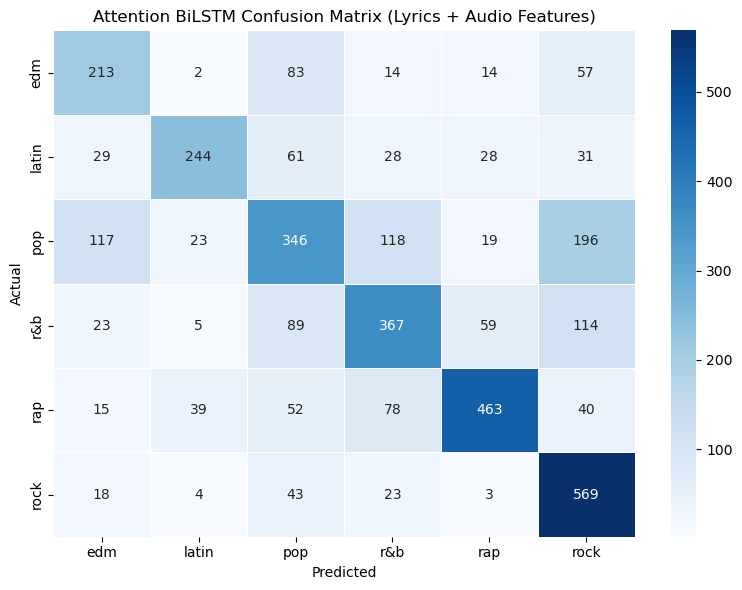

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a DataFrame for better labeling
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Attention BiLSTM Confusion Matrix (Lyrics + Audio Features)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

### 2. Only lyrics

In [75]:
class SongDataset(Dataset):
    def __init__(self, df, vocab):
        self.lyrics = [encode(text, vocab)[:MAX_SEQ_LEN] for text in df["lyrics"]]

        self.scaler = StandardScaler()
        self.labels = df["label"].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        lyric_tensor = torch.LongTensor(self.lyrics[idx])
        label_tensor = torch.LongTensor([self.labels[idx]])
        return lyric_tensor, label_tensor

def collate_fn(batch):
    lyrics, labels = zip(*batch)
    lyrics_padded = nn.utils.rnn.pad_sequence(lyrics, batch_first=True, padding_value=0)
    return lyrics_padded, torch.cat(labels)

In [76]:
def prepare_data(df, vocab, test_size=0.2, val_size=0.1):
    df = df.copy()
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df["playlist_genre"])
    num_classes = len(label_encoder.classes_)

    train_val_df, test_df = train_test_split(df, test_size=test_size, stratify=df["label"], random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, stratify=train_val_df["label"], random_state=42)

    train_dataset = SongDataset(train_df, vocab)
    val_dataset = SongDataset(val_df, vocab)
    test_dataset = SongDataset(test_df, vocab)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader, num_classes, label_encoder

In [115]:
class AttentionBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.dropout = nn.Dropout(0.5)

        # Attention
        self.attn_linear = nn.Linear(hidden_dim * 2, 1)

        # Final classifier with numerical features
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, lyrics):
        embed = self.embedding(lyrics)
        lstm_out, _ = self.lstm(embed)
        attn_weights = torch.softmax(self.attn_linear(lstm_out), dim=1)
        attn_output = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.classifier(attn_output)
        return out

In [116]:
model = AttentionBiLSTM(
    vocab_size=10000,
    embedding_dim=128,
    hidden_dim=128,
    num_classes=len(label_encoder.classes_)
).to(device)

In [117]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1578119


In [118]:
print(model)

AttentionBiLSTM(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn_linear): Linear(in_features=256, out_features=1, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [119]:
vocab = build_vocab(df["lyrics"])
train_loader, val_loader, test_loader, num_classes, label_encoder = prepare_data(df, vocab)

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [121]:
best_loss = float('inf')
patience = 3
counter = 0

for epoch in range(30):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for lyrics_batch, label_batch in train_loader:
        lyrics_batch, label_batch = (
            lyrics_batch.to(device),
            label_batch.to(device)
        )

        optimizer.zero_grad()
        output = model(lyrics_batch)
        loss = criterion(output, label_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        correct += (preds == label_batch).sum().item()
        total += label_batch.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    print(f"📚 Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for lyrics_batch, label_batch in test_loader:
            lyrics_batch, label_batch = (
                lyrics_batch.to(device),
                label_batch.to(device)
            )

            output = model(lyrics_batch)
            loss = criterion(output, label_batch)
            val_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            val_correct += (preds == label_batch).sum().item()
            val_total += label_batch.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    print(f"🧪 Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.4f}")

    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_only_lyrics.pt")
        print("✅ Best model saved.")
    
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

📚 Epoch 1, Train Loss: 1.5160, Train Acc: 0.3858
🧪 Validation Loss: 1.4204, Validation Acc: 0.4368
✅ Best model saved.
📚 Epoch 2, Train Loss: 1.3596, Train Acc: 0.4703
🧪 Validation Loss: 1.3470, Validation Acc: 0.4902
✅ Best model saved.
📚 Epoch 3, Train Loss: 1.2716, Train Acc: 0.5157
🧪 Validation Loss: 1.3191, Validation Acc: 0.5114
✅ Best model saved.
📚 Epoch 4, Train Loss: 1.1816, Train Acc: 0.5632
🧪 Validation Loss: 1.2613, Validation Acc: 0.5357
✅ Best model saved.
📚 Epoch 5, Train Loss: 1.0898, Train Acc: 0.5990
🧪 Validation Loss: 1.2461, Validation Acc: 0.5462
✅ Best model saved.
📚 Epoch 6, Train Loss: 1.0083, Train Acc: 0.6379
🧪 Validation Loss: 1.2669, Validation Acc: 0.5459
📚 Epoch 7, Train Loss: 0.9333, Train Acc: 0.6681
🧪 Validation Loss: 1.3049, Validation Acc: 0.5329
📚 Epoch 8, Train Loss: 0.8663, Train Acc: 0.6888
🧪 Validation Loss: 1.3795, Validation Acc: 0.5354
⏹️ Early stopping triggered.


In [122]:
model.load_state_dict(torch.load("best_model_only_lyrics.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for lyrics_batch, label_batch in test_loader:
        lyrics_batch = lyrics_batch.to(device)
        inputs = lyrics_batch
        output = model(lyrics_batch)
        preds = torch.argmax(output, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(label_batch.cpu().numpy())

print("\n🎯 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


🎯 Classification Report:
              precision    recall  f1-score   support

         edm       0.51      0.27      0.35       382
       latin       0.71      0.57      0.64       427
         pop       0.42      0.51      0.46       791
         r&b       0.48      0.44      0.46       661
         rap       0.70      0.72      0.71       666
        rock       0.55      0.65      0.60       702

    accuracy                           0.55      3629
   macro avg       0.56      0.53      0.54      3629
weighted avg       0.55      0.55      0.54      3629



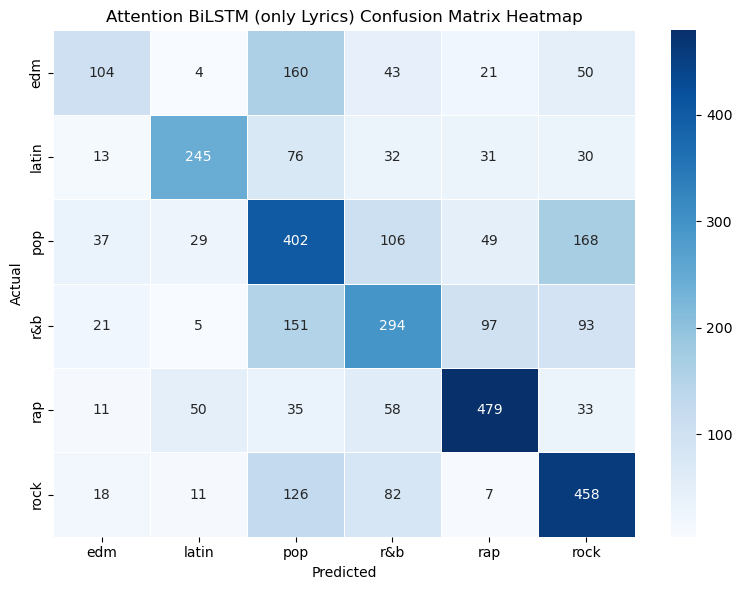

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a DataFrame for better labeling
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Attention BiLSTM (only Lyrics) Confusion Matrix Heatmap")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()